In [1]:
#Importing all the libraries
import numpy as np
import pandas as pd
import itertools
import time
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas import datetime
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

Importing plotly failed. Interactive plots will not work.
<ipython-input-1-813d92f22081>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
program_start_time=time.time()

## Understand the data set

In [3]:
#importing the production data
df=pd.read_csv('Production Quantity.csv')
df.head()

,start_date,end_date,prod,region_id
0,2015-01-01T00:00:00.000Z,2015-01-31T00:00:00.000Z,171725,93
1,2015-02-01T00:00:00.000Z,2015-02-28T00:00:00.000Z,188325,93
2,2015-03-01T00:00:00.000Z,2015-03-31T00:00:00.000Z,247856,93
3,2015-04-01T00:00:00.000Z,2015-04-30T00:00:00.000Z,282791,93
4,2015-05-01T00:00:00.000Z,2015-05-31T00:00:00.000Z,291057,93


In [4]:
df.shape

(720, 4)

In [5]:
#determining the data types of the attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   start_date  720 non-null    object
 1   end_date    720 non-null    object
 2   prod        720 non-null    int64 
 3   region_id   720 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.6+ KB


In [6]:
# Changing the format of start data in the dataframe. We are not changing the end date because we will be dropping it
df['start_date']=pd.to_datetime(df['start_date'])
df['start_date']=df['start_date'].dt.date
df['start_date']=pd.to_datetime(df['start_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  720 non-null    datetime64[ns]
 1   end_date    720 non-null    object        
 2   prod        720 non-null    int64         
 3   region_id   720 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 22.6+ KB


In [7]:
df.head()

,start_date,end_date,prod,region_id
0,2015-01-01,2015-01-31T00:00:00.000Z,171725,93
1,2015-02-01,2015-02-28T00:00:00.000Z,188325,93
2,2015-03-01,2015-03-31T00:00:00.000Z,247856,93
3,2015-04-01,2015-04-30T00:00:00.000Z,282791,93
4,2015-05-01,2015-05-31T00:00:00.000Z,291057,93


In [8]:
#sorting values by start date
df=df.sort_values(by=['start_date'])

In [9]:
# reading the preciptation dataset 
rain=pd.read_csv('Daily Precipitation.csv')

In [10]:
# reading the temperature dataset
temp=pd.read_csv('Daily Temperature.csv')
temp

,start_date,end_date,temp,region_id
0,2014-01-02T00:00:00.000Z,2014-01-02T00:00:00.000Z,24.707605,93
1,2014-01-11T00:00:00.000Z,2014-01-11T00:00:00.000Z,26.421176,93
2,2014-01-15T00:00:00.000Z,2014-01-15T00:00:00.000Z,24.305642,93
3,2014-01-20T00:00:00.000Z,2014-01-20T00:00:00.000Z,25.142744,93
4,2014-01-23T00:00:00.000Z,2014-01-23T00:00:00.000Z,23.653173,93
...,...,...,...,...
12925,2022-03-02T00:00:00.000Z,2022-03-02T00:00:00.000Z,24.402574,105
12926,2022-03-08T00:00:00.000Z,2022-03-08T00:00:00.000Z,29.217803,105
12927,2022-03-11T00:00:00.000Z,2022-03-11T00:00:00.000Z,26.027421,105
12928,2022-03-12T00:00:00.000Z,2022-03-12T00:00:00.000Z,27.108212,105


In [11]:
# reading the soil mositure dataset
soil=pd.read_csv('Daily Soil Mositure.csv')
soil.head()

,start_date,end_date,smos,region_id
0,2014-01-01T00:00:00.000Z,2014-01-01T00:00:00.000Z,0.310787,93
1,2014-01-02T00:00:00.000Z,2014-01-02T00:00:00.000Z,0.192271,93
2,2014-01-03T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.265683,93
3,2014-01-04T00:00:00.000Z,2014-01-04T00:00:00.000Z,0.265683,93
4,2014-01-05T00:00:00.000Z,2014-01-05T00:00:00.000Z,0.230782,93


In [12]:
#reading the ndvi dataset
ndvi=pd.read_csv('Eight Day NDVI.csv')
ndvi

,start_date,end_date,ndvi,region_id
0,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.679106,93
1,2014-01-01T00:00:00.000Z,2014-01-08T00:00:00.000Z,0.701431,93
2,2014-01-09T00:00:00.000Z,2014-01-16T00:00:00.000Z,0.745149,93
3,2014-01-17T00:00:00.000Z,2014-01-24T00:00:00.000Z,0.747391,93
4,2014-01-25T00:00:00.000Z,2014-02-01T00:00:00.000Z,0.768325,93
...,...,...,...,...
3333,2022-01-09T00:00:00.000Z,2022-01-16T00:00:00.000Z,0.798257,105
3334,2022-01-17T00:00:00.000Z,2022-01-24T00:00:00.000Z,0.793242,105
3335,2022-01-25T00:00:00.000Z,2022-02-01T00:00:00.000Z,0.804884,105
3336,2022-02-18T00:00:00.000Z,2022-02-25T00:00:00.000Z,0.776287,105


In [13]:
#converting the date to datetime foramt and getting the data value from the date.
rain['start_date']=pd.to_datetime(rain['start_date'])
rain['start_date']=rain['start_date'].dt.date
rain['start_date']=pd.to_datetime(rain['start_date'])
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29940 entries, 0 to 29939
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  29940 non-null  datetime64[ns]
 1   end_date    29940 non-null  object        
 2   precip      29940 non-null  float64       
 3   region_id   29940 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 935.8+ KB


In [14]:
#converting the date to datetime foramt and getting the data value from the date.
temp['start_date']=pd.to_datetime(temp['start_date'])
temp['start_date']=temp['start_date'].dt.date
temp['start_date']=pd.to_datetime(temp['start_date'])
temp['end_date']=pd.to_datetime(temp['end_date'])
temp['end_date']=temp['end_date'].dt.date
temp['end_date']=pd.to_datetime(temp['end_date'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12930 entries, 0 to 12929
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  12930 non-null  datetime64[ns]
 1   end_date    12930 non-null  datetime64[ns]
 2   temp        12930 non-null  float64       
 3   region_id   12930 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 404.2 KB


In [15]:
#converting the date to datetime foramt and getting the data value from the date.
soil['start_date']=pd.to_datetime(soil['start_date'])
soil['start_date']=soil['start_date'].dt.date
soil['start_date']=pd.to_datetime(soil['start_date'])
soil['end_date']=pd.to_datetime(soil['end_date'])
soil['end_date']=soil['end_date'].dt.date
soil['end_date']=pd.to_datetime(soil['end_date'])
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29603 entries, 0 to 29602
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  29603 non-null  datetime64[ns]
 1   end_date    29603 non-null  datetime64[ns]
 2   smos        29603 non-null  float64       
 3   region_id   29603 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 925.2 KB


In [16]:
#index=rain.set_index(rain['start_date'],drop=False)
index=rain[['start_date','precip','region_id']]
index

,start_date,precip,region_id
0,2014-01-01,1.392393,93
1,2014-01-02,0.315380,93
2,2014-01-03,2.347846,93
3,2014-01-04,21.466357,93
4,2014-01-05,32.823651,93
...,...,...,...
29935,2022-03-09,0.041747,105
29936,2022-03-10,0.090011,105
29937,2022-03-11,0.021150,105
29938,2022-03-12,0.092205,105


In [17]:
#setting start date as index
index=index.set_index('start_date',drop=True)
index

,precip,region_id
start_date,,
2014-01-01,1.392393,93
2014-01-02,0.315380,93
2014-01-03,2.347846,93
2014-01-04,21.466357,93
2014-01-05,32.823651,93
...,...,...
2022-03-09,0.041747,105
2022-03-10,0.090011,105
2022-03-11,0.021150,105


In [18]:
#Rolling up the precipitation data  to monthly level
grouped=index.groupby(by=['region_id'])['precip'].resample('MS').sum()

In [19]:
grouped=grouped.reset_index()
grouped=pd.DataFrame(grouped)

In [20]:
grouped

,region_id,start_date,precip
0,93,2014-01-01,78.794493
1,93,2014-02-01,9.128431
2,93,2014-03-01,192.463191
3,93,2014-04-01,313.000183
4,93,2014-05-01,283.982665
...,...,...,...
985,105,2021-11-01,481.716550
986,105,2021-12-01,448.876312
987,105,2022-01-01,12.799437
988,105,2022-02-01,752.755545


In [21]:
temp_df=temp[['start_date','region_id','temp']]
temp_df

,start_date,region_id,temp
0,2014-01-02,93,24.707605
1,2014-01-11,93,26.421176
2,2014-01-15,93,24.305642
3,2014-01-20,93,25.142744
4,2014-01-23,93,23.653173
...,...,...,...
12925,2022-03-02,105,24.402574
12926,2022-03-08,105,29.217803
12927,2022-03-11,105,26.027421
12928,2022-03-12,105,27.108212


In [22]:
#rolling up the temperature data at a monthly level
temp_df.set_index('start_date',drop=True,inplace=True)
temp_grouped=temp_df.groupby(by=['region_id'])['temp'].resample('MS').mean()
temp_grouped=temp_grouped.reset_index()
temp_grouped=pd.DataFrame(temp_grouped)


In [23]:
soil_df=soil[['start_date','region_id','smos']]

In [24]:
#rolling up the soil data at a monthly level
soil_df.set_index('start_date',drop=True,inplace=True)
soil_grouped=soil_df.groupby(by=['region_id'])['smos'].resample('MS').mean()
soil_grouped=soil_grouped.reset_index()
soil_grouped=pd.DataFrame(soil_grouped)

In [25]:
#sorting ndvi data by start date and using it as index
ndvi=ndvi.sort_values(by=['start_date'])
ndvi.reset_index(drop=True,inplace=True)

In [26]:
ndvi

,start_date,end_date,ndvi,region_id
0,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.679106,93
1,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.751093,97
2,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.784205,99
3,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.759486,102
4,2013-12-27T00:00:00.000Z,2014-01-03T00:00:00.000Z,0.747496,103
...,...,...,...,...
3333,2022-03-06T00:00:00.000Z,2022-03-13T00:00:00.000Z,0.814690,103
3334,2022-03-06T00:00:00.000Z,2022-03-13T00:00:00.000Z,0.817047,98
3335,2022-03-06T00:00:00.000Z,2022-03-13T00:00:00.000Z,0.816218,99
3336,2022-03-06T00:00:00.000Z,2022-03-13T00:00:00.000Z,0.811705,93


In [27]:
#Extracting date from start date and converting to datetime format.
#We are converting to datetime format before and after extracting the date beacause it gets converted back to object dtype.  
ndvi['start_date']=pd.to_datetime(ndvi['start_date'])
ndvi['start_date']=ndvi['start_date'].dt.date
ndvi['start_date']=pd.to_datetime(ndvi['start_date'])
ndvi['end_date']=pd.to_datetime(ndvi['end_date'])
ndvi['end_date']=ndvi['end_date'].dt.date
ndvi['end_date']=pd.to_datetime(ndvi['end_date'])
ndvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338 entries, 0 to 3337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  3338 non-null   datetime64[ns]
 1   end_date    3338 non-null   datetime64[ns]
 2   ndvi        3338 non-null   float64       
 3   region_id   3338 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 104.4 KB


In [28]:
ndvi

,start_date,end_date,ndvi,region_id
0,2013-12-27,2014-01-03,0.679106,93
1,2013-12-27,2014-01-03,0.751093,97
2,2013-12-27,2014-01-03,0.784205,99
3,2013-12-27,2014-01-03,0.759486,102
4,2013-12-27,2014-01-03,0.747496,103
...,...,...,...,...
3333,2022-03-06,2022-03-13,0.814690,103
3334,2022-03-06,2022-03-13,0.817047,98
3335,2022-03-06,2022-03-13,0.816218,99
3336,2022-03-06,2022-03-13,0.811705,93


In [29]:
ndvi_df=ndvi[['start_date','region_id','ndvi']]
ndvi_df

,start_date,region_id,ndvi
0,2013-12-27,93,0.679106
1,2013-12-27,97,0.751093
2,2013-12-27,99,0.784205
3,2013-12-27,102,0.759486
4,2013-12-27,103,0.747496
...,...,...,...
3333,2022-03-06,103,0.814690
3334,2022-03-06,98,0.817047
3335,2022-03-06,99,0.816218
3336,2022-03-06,93,0.811705


In [30]:
# rolling up ndvi data to monthly level by mean value
ndvi_df.set_index('start_date',drop=True,inplace=True)
ndvi_grouped=ndvi_df.groupby(by=['region_id'])['ndvi'].resample('MS').mean()
ndvi_grouped=ndvi_grouped.reset_index()
ndvi_grouped=pd.DataFrame(ndvi_grouped)

In [31]:
ndvi_grouped

,region_id,start_date,ndvi
0,93,2013-12-01,0.679106
1,93,2014-01-01,0.740574
2,93,2014-02-01,0.766015
3,93,2014-03-01,0.734051
4,93,2014-04-01,0.807792
...,...,...,...
992,105,2021-11-01,0.806877
993,105,2021-12-01,0.801862
994,105,2022-01-01,0.804893
995,105,2022-02-01,0.776287


In [32]:
#Finally merging all the data sources into a single dataframe
final_data=pd.merge(df,grouped,on=['region_id','start_date'],how='left').\
merge(temp_grouped,on=['region_id','start_date'],how='left').\
merge(soil_grouped,on=['region_id','start_date'],how='left').\
merge(ndvi_grouped,on=['region_id','start_date'],how='left')
final_data

,start_date,end_date,prod,region_id,precip,temp,smos,ndvi
0,2015-01-01,2015-01-31T00:00:00.000Z,171725,93,136.228017,25.003593,0.318552,0.761228
1,2015-01-01,2015-01-31T00:00:00.000Z,11181,95,47.132000,23.126085,0.374408,0.745063
2,2015-01-01,2015-01-31T00:00:00.000Z,141442,98,86.524596,24.094009,0.281108,0.778641
3,2015-01-01,2015-01-31T00:00:00.000Z,116186,99,90.742837,25.246834,0.325131,0.787046
4,2015-01-01,2015-01-31T00:00:00.000Z,15066,94,44.773402,26.559232,0.268754,0.768596
...,...,...,...,...,...,...,...,...
715,2020-12-01,2020-12-31T00:00:00.000Z,24683,95,250.758428,24.130821,0.337349,0.791458
716,2020-12-01,2020-12-31T00:00:00.000Z,10714,94,218.018188,25.381922,0.361331,0.803116
717,2020-12-01,2020-12-31T00:00:00.000Z,217480,93,194.400823,24.860753,0.417944,0.813459
718,2020-12-01,2020-12-31T00:00:00.000Z,32747,104,192.648891,26.492564,0.383109,0.790809


In [33]:
#checking for null and duplicate values
final_data.isnull().sum()

start_date    0
end_date      0
prod          0
region_id     0
precip        0
temp          0
smos          0
ndvi          4
dtype: int64

In [34]:
final_data[final_data.duplicated()]

,start_date,end_date,prod,region_id,precip,temp,smos,ndvi


In [35]:
final_data.drop(columns=['end_date'],inplace=True)
final_data

,start_date,prod,region_id,precip,temp,smos,ndvi
0,2015-01-01,171725,93,136.228017,25.003593,0.318552,0.761228
1,2015-01-01,11181,95,47.132000,23.126085,0.374408,0.745063
2,2015-01-01,141442,98,86.524596,24.094009,0.281108,0.778641
3,2015-01-01,116186,99,90.742837,25.246834,0.325131,0.787046
4,2015-01-01,15066,94,44.773402,26.559232,0.268754,0.768596
...,...,...,...,...,...,...,...
715,2020-12-01,24683,95,250.758428,24.130821,0.337349,0.791458
716,2020-12-01,10714,94,218.018188,25.381922,0.361331,0.803116
717,2020-12-01,217480,93,194.400823,24.860753,0.417944,0.813459
718,2020-12-01,32747,104,192.648891,26.492564,0.383109,0.790809


In [36]:
#ndvi change to mean
final_data.fillna(0,inplace=True)

## Seasonal Decomposition

We are performing seasonal decomposition to identify the seasonality in the data. It breaks the time series data to three components 
- Trend component - Gives the overall trend of the data 
- Seasonal component - Gives the overall seasonality in the data. 
- Residual component - Gives the amount errors in the data.

The seasonality which gives the least amount of errors(residuals) should be chosen.
In our case we are choosing yearly seasonality

<Figure size 576x576 with 0 Axes>

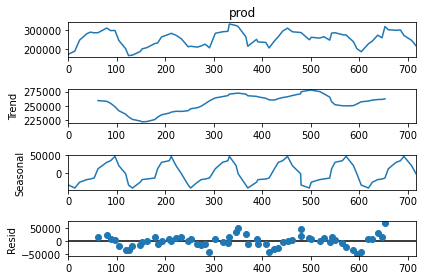

<Figure size 576x576 with 0 Axes>

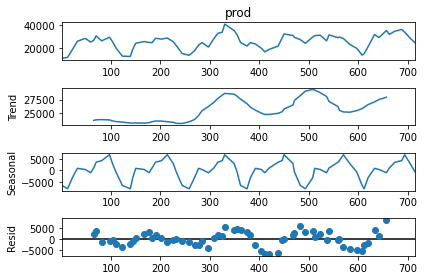

<Figure size 576x576 with 0 Axes>

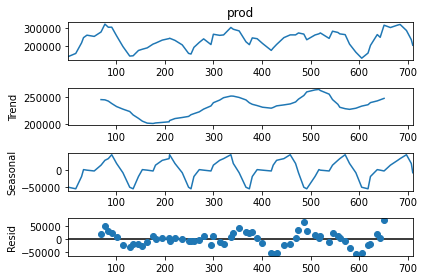

<Figure size 576x576 with 0 Axes>

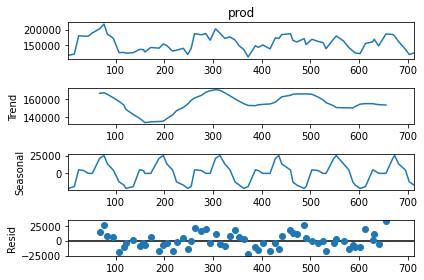

<Figure size 576x576 with 0 Axes>

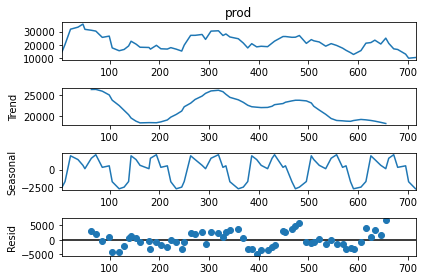

<Figure size 576x576 with 0 Axes>

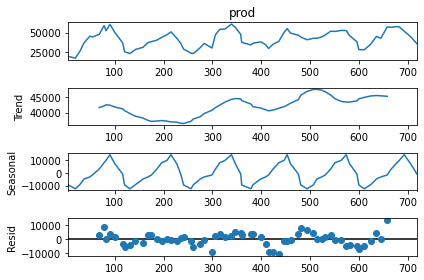

<Figure size 576x576 with 0 Axes>

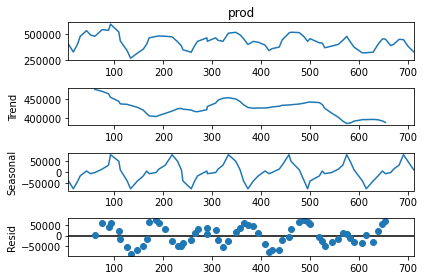

<Figure size 576x576 with 0 Axes>

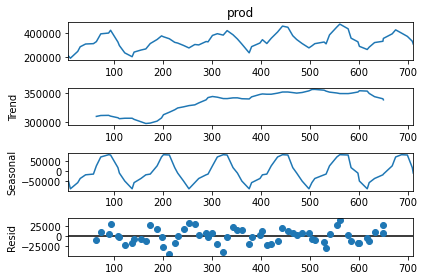

<Figure size 576x576 with 0 Axes>

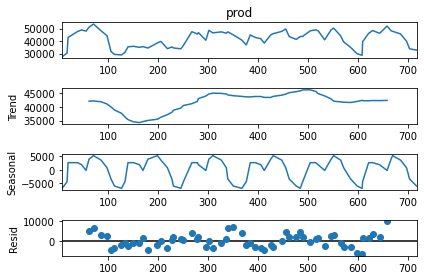

<Figure size 576x576 with 0 Axes>

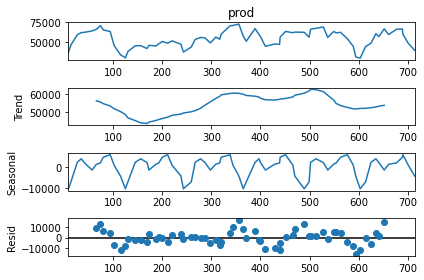

In [37]:
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    result = seasonal_decompose(region_df['prod'], model='additive', period=12)
    plt.figure(figsize=(8,8))
    result.plot()
    plt.show()

## ACF AND PACF Plot

We plot ACF and PACF plot to identify the hyperparameters (p,q) for the stats models.
- ACF Plot: ACF plot is a bar chart of coefficients of correlation between a time series and its lagged values. It is to    identify the p value. The most correlated lag term.
- PACF Plot: The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself. It is used to identify the q value. 


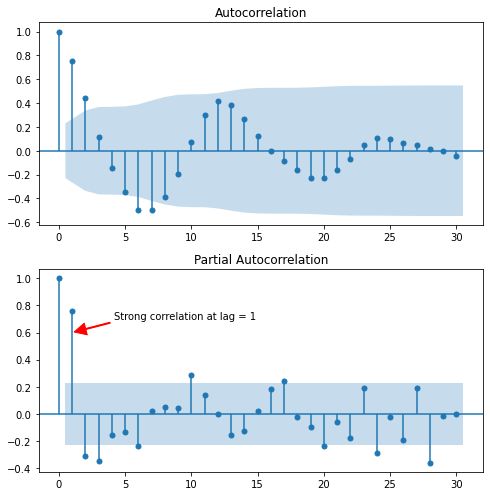

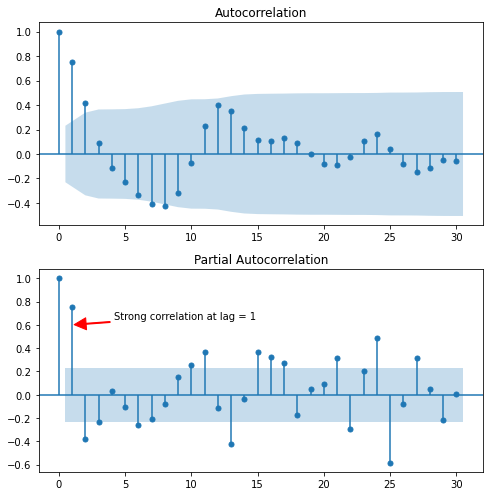

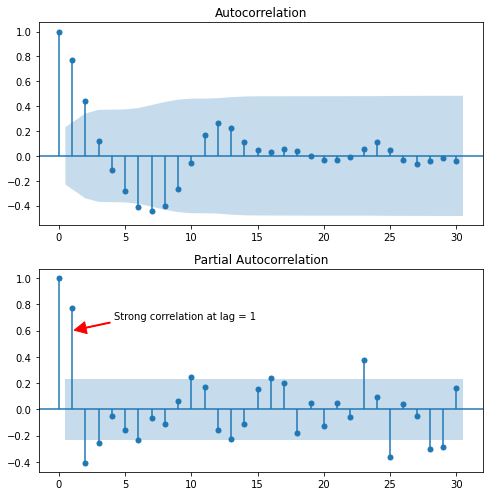

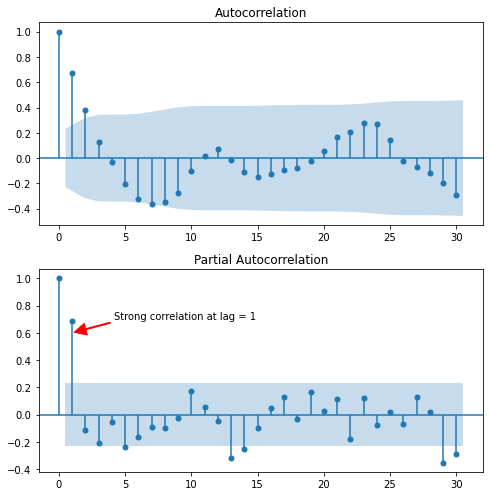

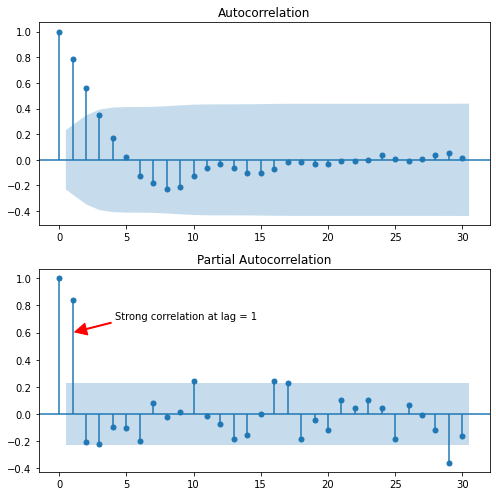

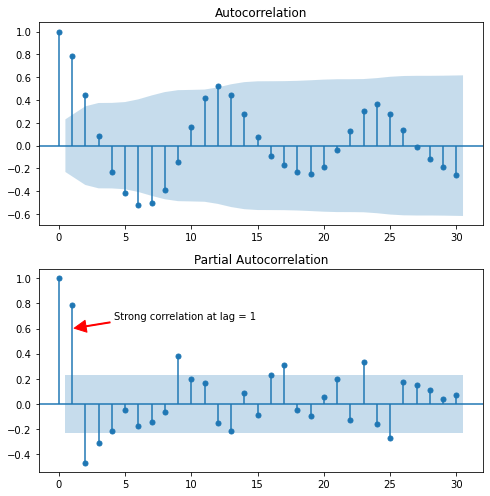

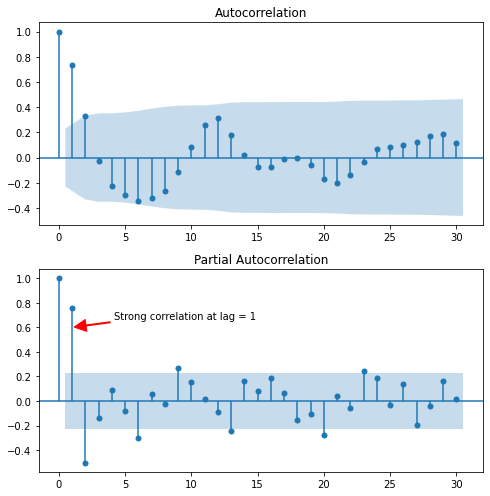

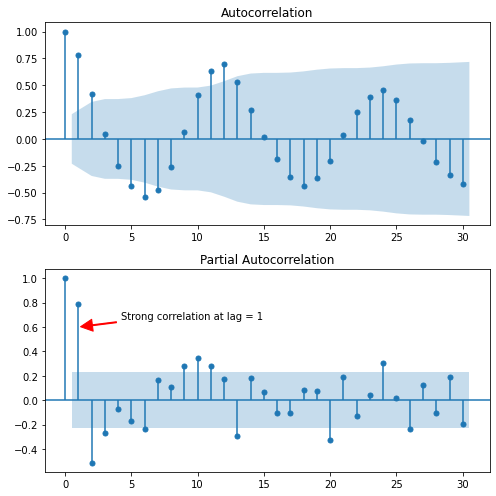

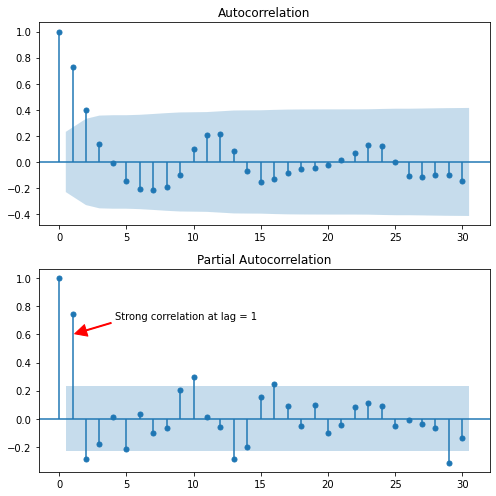

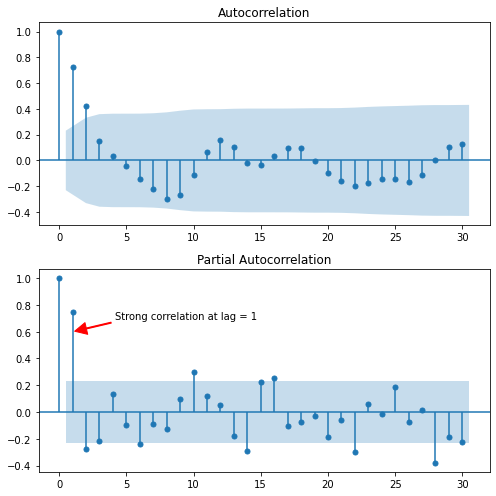

In [38]:
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,7))
    plot_acf(region_df['prod'],lags=30, ax=ax[0])
    plot_pacf(region_df['prod'],lags=30, ax=ax[1], method='ols')

    ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
                xytext=(0.17, 0.75), textcoords='axes fraction',
                arrowprops=dict(color='red', shrink=0.05, width=1))

    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis

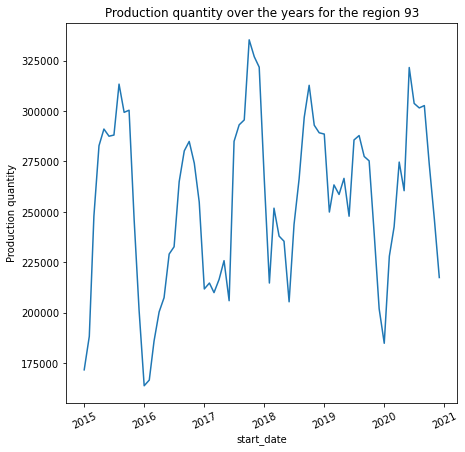

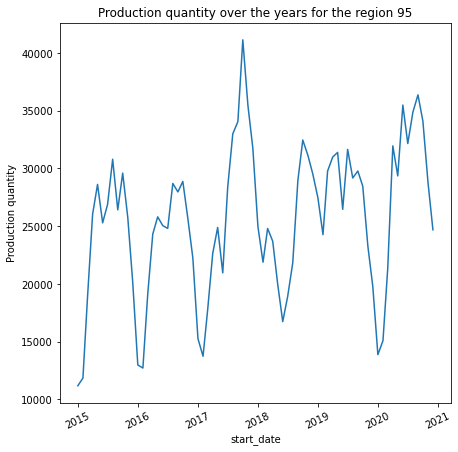

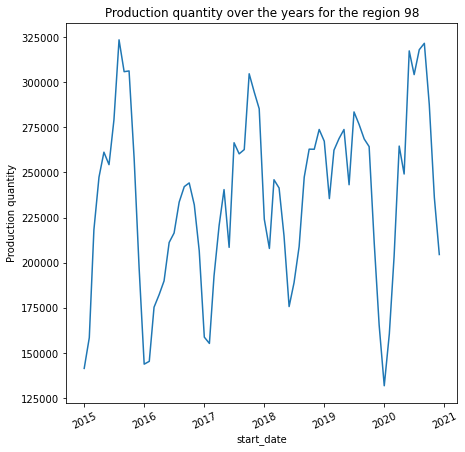

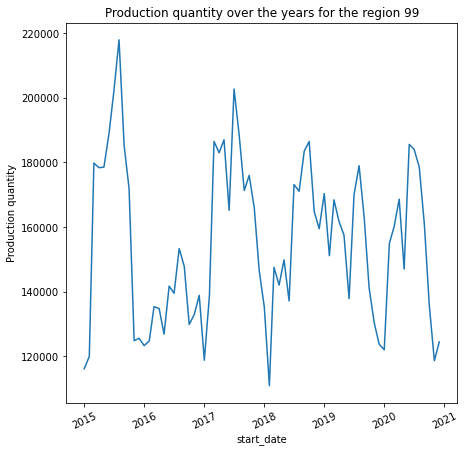

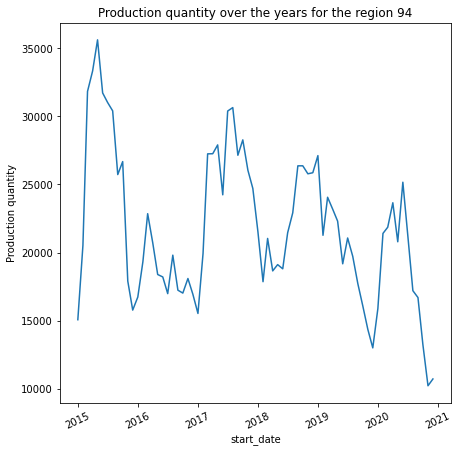

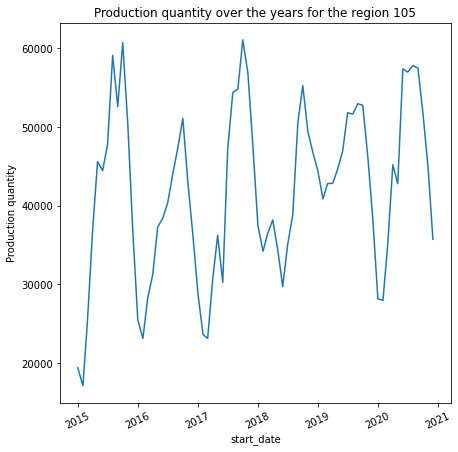

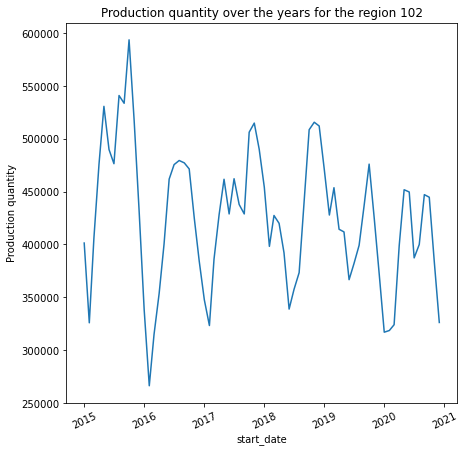

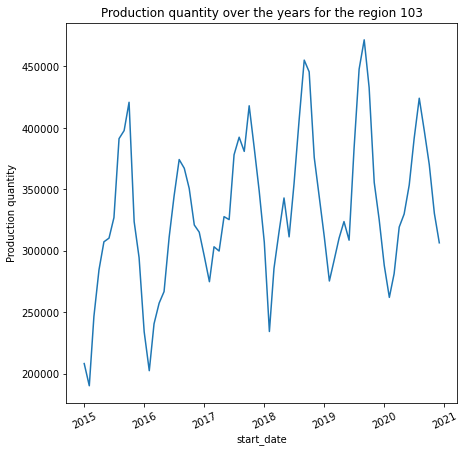

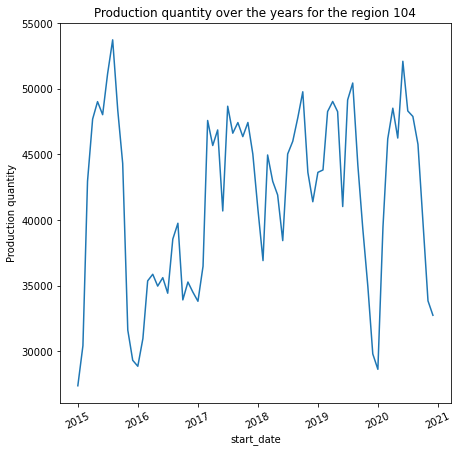

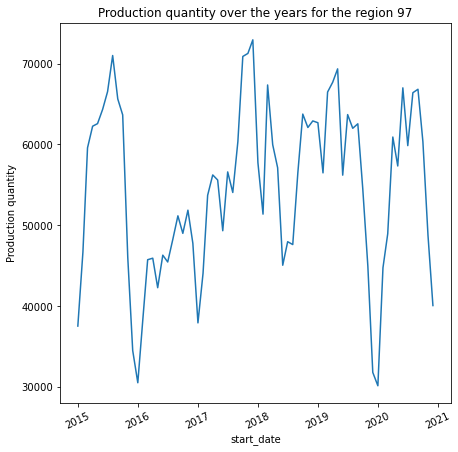

In [39]:
# Plotting the production quantity for various regions. 
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    region_df.set_index('start_date',inplace=True)
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
    sns.lineplot(x = "start_date", y = "prod", data = region_df,ax=ax)
    plt.title("Production quantity over the years for the region {}".format(i))
    plt.ylabel("Production quantity")
    plt.xticks(rotation = 25) 

In [40]:
#function to calculate MAPE. 
def calculate_mape(actual, predicted):
  
    if not all([isinstance(actual, np.ndarray),isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
  
    # Calculate the MAPE value and return
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

## ADF Test

ADF test is performed to check if the data is stationary or not.
It tests the null hypothesis that a unit root is present in a time series sample
If the data is stationary then we will have to difference the data.

In [41]:
#function to perform ADF test

def adf_test(series):
    result = adfuller(series)
    if result[1]>=0.05:
        return 1
    else:
        return 0

In [42]:
# Feature enginnering the date column into several subsets of date column

final_data['dayofweek'] = final_data['start_date'].dt.dayofweek
final_data['quarter'] = final_data['start_date'].dt.quarter
final_data['month'] = final_data['start_date'].dt.month
final_data['year'] = final_data['start_date'].dt.year
final_data['dayofyear'] = final_data['start_date'].dt.dayofyear
final_data['weekofyear'] = final_data['start_date'].dt.weekofyear
final_data['month_sin'] = np.sin(2 * np.pi * final_data['month']/12.0)
final_data['month_cos'] = np.cos(2 * np.pi * final_data['month']/12.0)
final_data

,start_date,prod,region_id,precip,temp,smos,ndvi,dayofweek,quarter,month,year,dayofyear,weekofyear,month_sin,month_cos
0,2015-01-01,171725,93,136.228017,25.003593,0.318552,0.761228,3,1,1,2015,1,1,5.000000e-01,0.866025
1,2015-01-01,11181,95,47.132000,23.126085,0.374408,0.745063,3,1,1,2015,1,1,5.000000e-01,0.866025
2,2015-01-01,141442,98,86.524596,24.094009,0.281108,0.778641,3,1,1,2015,1,1,5.000000e-01,0.866025
3,2015-01-01,116186,99,90.742837,25.246834,0.325131,0.787046,3,1,1,2015,1,1,5.000000e-01,0.866025
4,2015-01-01,15066,94,44.773402,26.559232,0.268754,0.768596,3,1,1,2015,1,1,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2020-12-01,24683,95,250.758428,24.130821,0.337349,0.791458,1,4,12,2020,336,49,-2.449294e-16,1.000000
716,2020-12-01,10714,94,218.018188,25.381922,0.361331,0.803116,1,4,12,2020,336,49,-2.449294e-16,1.000000
717,2020-12-01,217480,93,194.400823,24.860753,0.417944,0.813459,1,4,12,2020,336,49,-2.449294e-16,1.000000
718,2020-12-01,32747,104,192.648891,26.492564,0.383109,0.790809,1,4,12,2020,336,49,-2.449294e-16,1.000000


<AxesSubplot:>

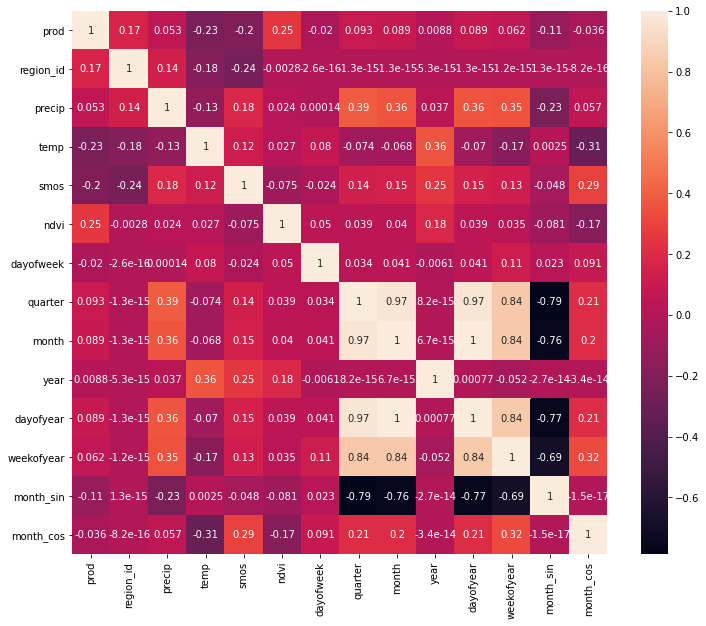

In [43]:
#correlation plot to identify the correlation between variables
# from the plot we can see that the ndvi metric is highly correlated
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.heatmap(final_data.corr(),annot=True)

In [44]:
#function to find the best p and q paramters for arima
# AIC is used as a metric to identify the best paramters within the same model
def best_params_arima(series,d):
    # Define the p,and q parameters to take any value between 0 and 3
    p=q=range(0, 3)
    # Generate all different combinations of p and q 
    pq = list(itertools.product(p,q))
    bestAIC = np.inf
    bestparam = None 
    for param in pq:
        try:
            model = ARIMA(series,order=(param[0],d,param[1]))
            results = model.fit()
            #if current run of AIC is better than the best one so far, overwrite it
            if results.aic<bestAIC:
                bestAIC = results.aic
                bestparam = param
        except:
            continue
    return bestparam

## Univariate ARIMA

In [45]:
# performing ARIMA without exogenous variables
pred_arima=pd.DataFrame()
# creating a dictionary to store the mape and r2 scores by region
mape_dic={}
r2_dic={}
#creating a dictionary to store the best parameters for each model
params_arima={}

#running a loop to forecast 12 months for each region
for i in final_data['region_id'].unique():
    
    region_df=final_data[final_data['region_id']==i]
    # train test split (train : 60 months and test 12 months)
    train=region_df[:60]
    test=region_df[60:]
    # setting date as index
    train.set_index('start_date',inplace=True)
    # getting the best 'd' value using adf test
    d=adf_test(train['prod'])
    # finding the best p and q values using grid search
    params=best_params_arima(train['prod'],d)
    # model fitting and predictions
    
    arima= ARIMA(train['prod'],order=(1,d,1)).fit()
    preds_arima=arima.predict(start=train.shape[0],end=region_df.shape[0]-1)
    preds_arima=abs(preds_arima)
    
    #storing the results in a dataframe along with the region id to plot it 
    results=preds_arima.to_frame()
    results['region_id']=i
    pred_arima=pd.concat([pred_arima,results],axis=0)
    
    #calculating mape and r2 and storing it in 2 dictionaries
    error=calculate_mape(test['prod'],preds_arima)
    mape_dic[i]=error
    r2=r2_score(test['prod'],preds_arima)
    r2_dic[i]=r2
    
    #storing the best params for each arima model in a dictionary to use it for testing
    params_arima[i]=(params[0],d,params[1]) 

In [46]:
pred_arima

,predicted_mean,region_id
2020-01-01,207895.027321,93
2020-02-01,220973.430558,93
2020-03-01,230370.157430,93
2020-04-01,237121.629634,93
2020-05-01,241972.507767,93
...,...,...
2020-08-01,27656.498175,97
2020-09-01,27655.921226,97
2020-10-01,27655.720418,97
2020-11-01,27655.650526,97


In [47]:
params_arima

{93: (2, 0, 1),
 95: (2, 1, 2),
 98: (2, 0, 1),
 99: (2, 0, 1),
 94: (2, 1, 0),
 105: (2, 1, 2),
 102: (2, 0, 1),
 103: (2, 1, 2),
 104: (2, 0, 0),
 97: (2, 1, 2)}

In [48]:
r2_dic

{93: -0.0009310744697959006,
 95: -1.644696066056523,
 98: 0.09413979519137472,
 99: 0.017755074819692962,
 94: -1.828398792801742,
 105: -1.0426920367688575,
 102: -0.1586605535955723,
 103: -0.33675728320226517,
 104: -0.17200226572302135,
 97: -5.551820193388966}

## Multivariate ARIMA

In [109]:
# performing arima using exogeneous variables

#creating the datafrae to store prediction results
pred_arimax=pd.DataFrame()
mape_arimax={}
params_arimax={}
r2_arimax={}

#following the same procedure used in arima for arimax

for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    train.set_index('start_date',inplace=True)
    
    #defining the exogeneous variables used
    exog_train=train[['precip','temp','ndvi','dayofyear','weekofyear','year','month_sin','month_cos']]
    exog_test=test[['precip','temp','ndvi','dayofyear','weekofyear','year','month_sin','month_cos']]
    d=adf_test(train['prod'])
    
    params=best_params_arima(train['prod'],d)
    arima= ARIMA(train['prod'],order=(1,0,1),exog=exog_train).fit()
    preds_arimax=arima.predict(start=train.shape[0],end=region_df.shape[0]-1,exog=exog_test)
    preds_arimax=abs(preds_arimax)
    
    results=preds_arimax.to_frame()
    results['region_id']=i
    # storing the results for all the regions
    pred_arimax=pd.concat([pred_arimax,results],axis=0)
    error=calculate_mape(test['prod'],preds_arimax)
    r2=r2_score(test['prod'],preds_arimax)
    r2_arimax[i]=r2
    mape_arimax[i]=error
    params_arimax[i]=(params[0],d,params[1]) 

In [50]:
pred_arimax

,predicted_mean,region_id
2020-01-01,199942.416492,93
2020-02-01,206056.650090,93
2020-03-01,213887.404987,93
2020-04-01,226278.797468,93
2020-05-01,228540.578887,93
...,...,...
2020-08-01,32836.483215,97
2020-09-01,34515.155271,97
2020-10-01,33081.272408,97
2020-11-01,30262.528344,97


In [51]:
mape_arimax

{93: 11.35,
 95: 29.03,
 98: 15.7,
 99: 10.04,
 94: 19.34,
 105: 15.44,
 102: 8.48,
 103: 4.62,
 104: 9.3,
 97: 39.19}

In [52]:
params_arimax

{93: (2, 0, 1),
 95: (2, 1, 2),
 98: (2, 0, 1),
 99: (2, 0, 1),
 94: (2, 1, 0),
 105: (2, 1, 2),
 102: (2, 0, 1),
 103: (2, 1, 2),
 104: (2, 0, 0),
 97: (2, 1, 2)}

In [53]:
# defining a function to identify the best parameters for SARIMA.
# SARIMA uses seasonal paramters in addition to (p,d,q) and also uses the seasonality. We are using yearly seasonality 

def sarima_params(series,d):
    p=q=range(0, 3)
    pq = list(itertools.product(p,q))
    seasonal_pdq = [(x[0], d, x[1], 12) for x in list(itertools.product(p,q))]
    bestAIC = np.inf
    bestParam = None
    bestSParam = None
    
    print('Running GridSearch')
    
    #use gridsearch to look for optimial sarima parameters
    for param in pq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=(param[0],d,param[1]),
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #if current run of AIC is better than the best one so far, overwrite it
                if results.aic<bestAIC:
                    bestAIC = results.aic
                    bestParam = param
                    bestSParam = param_seasonal

            except:
                continue
    return bestParam,bestSParam

In [54]:
#SARIMA

# we are using the same process as used in ARIMA and ARIMAX. 
start=time.time()
pred_sarima=pd.DataFrame()
sarima_dic={}
params_sarima={}
r2_sarima={}
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    train.set_index('start_date',inplace=True)
    d=adf_test(train['prod'])
    # getting the best paramters and seasonal parameters using grid search
    params,sparams=sarima_params(train['prod'],d)
    arima= sm.tsa.statespace.SARIMAX(train['prod'],order=(params[0],d,params[1]),seasonal_order=sparams).fit()
    preds_sarima=arima.predict(start=train.shape[0],end=region_df.shape[0]-1)
    preds_sarima=abs(preds_sarima)
    results=preds_sarima.to_frame()
    results['region_id']=i
    pred_sarima=pd.concat([pred_sarima,results],axis=0)
    error=calculate_mape(test['prod'],preds_sarima)
    r2=r2_score(test['prod'],preds_sarima)
    r2_sarima[i]=r2
    sarima_dic[i]=error
    params_sarima[i]=(params[0],d,params[1],sparams[0],d,sparams[1]) 
end=time.time()
print("time taken:",end-start)

Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
time taken: 118.10329127311707


In [55]:
pred_sarima

,predicted_mean,region_id
2020-01-01,193442.408818,93
2020-02-01,167172.053151,93
2020-03-01,175505.349063,93
2020-04-01,170685.519154,93
2020-05-01,171275.602865,93
...,...,...
2020-08-01,36594.922557,97
2020-09-01,36877.183240,97
2020-10-01,31447.537825,97
2020-11-01,23797.190202,97


In [56]:
sarima_dic

{93: 36.52,
 95: 57.79,
 98: 49.85,
 99: 14.06,
 94: 19.3,
 105: 20.77,
 102: 17.87,
 103: 7.21,
 104: 34.63,
 97: 39.7}

In [57]:
params_sarima

{93: (2, 0, 2, 0, 0, 0),
 95: (1, 1, 1, 1, 1, 1),
 98: (2, 0, 2, 0, 0, 0),
 99: (2, 0, 2, 2, 0, 0),
 94: (0, 1, 2, 0, 1, 1),
 105: (0, 1, 2, 2, 1, 1),
 102: (1, 0, 2, 1, 0, 0),
 103: (2, 1, 2, 0, 1, 1),
 104: (2, 0, 2, 0, 0, 0),
 97: (2, 1, 1, 2, 1, 1)}

In [58]:
#SARIMAX
# We follow the same steps as the above three models. We will be using exogenous variables in the model
import statsmodels.api as sm
import time
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
start=time.time()
pred_sarimax=pd.DataFrame()
sarimax_dic={}
params_sarimax={}
r2_sarimax={}
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    train.set_index('start_date',inplace=True)
    
    #defining the exogenous variables
    
    exog_train=train[['precip','temp','ndvi','dayofyear','weekofyear','year','month_sin','month_cos']]
    exog_test=test[['precip','temp','ndvi','dayofyear','weekofyear','year','month_sin','month_cos']]
    d=adf_test(train['prod'])
    # getting the best params and seasonal params from gridsearch
    params,sparams=sarima_params(train['prod'],d)
    arima= sm.tsa.statespace.SARIMAX(train['prod'],order=(params[0],d,params[1]),seasonal_order=sparams,exog=exog_train).fit()
    preds_sarimax=arima.predict(start=train.shape[0],end=region_df.shape[0]-1,exog=exog_test)
    preds_sarimax=abs(preds_sarimax)
    results=preds_sarimax.to_frame()
    results['region_id']=i
    pred_sarimax=pd.concat([pred_sarimax,results],axis=0)
    error=calculate_mape(test['prod'],preds_sarimax)
    r2=r2_score(test['prod'],preds_sarimax)
    r2_sarimax[i]=r2
    sarimax_dic[i]=error
    params_sarimax[i]=(params[0],d,params[1],sparams[0],d,sparams[1]) 
end=time.time()
print("time taken:",end-start)

Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
Running GridSearch
time taken: 126.38867712020874


In [59]:
pred_sarimax

,predicted_mean,region_id
2020-01-01,207624.976838,93
2020-02-01,211825.311632,93
2020-03-01,217838.894093,93
2020-04-01,241246.362263,93
2020-05-01,255413.682619,93
...,...,...
2020-08-01,23306.818538,97
2020-09-01,22782.697762,97
2020-10-01,18971.605639,97
2020-11-01,4541.701599,97


In [60]:
sarimax_dic

{93: 7.8,
 95: 27.11,
 98: 15.01,
 99: 11.76,
 94: 73.11,
 105: 16.49,
 102: 9.39,
 103: 9.19,
 104: 10.26,
 97: 58.35}

In [61]:
params_sarimax

{93: (2, 0, 2, 0, 0, 0),
 95: (1, 1, 1, 1, 1, 1),
 98: (2, 0, 2, 0, 0, 0),
 99: (2, 0, 2, 2, 0, 0),
 94: (0, 1, 2, 0, 1, 1),
 105: (0, 1, 2, 2, 1, 1),
 102: (1, 0, 2, 1, 0, 0),
 103: (2, 1, 2, 0, 1, 1),
 104: (2, 0, 2, 0, 0, 0),
 97: (2, 1, 1, 2, 1, 1)}

## MULTIVARIATE UCM

In [62]:
# function to identify best parameters for UCM

def ucm_best_params(train,exog_train,test,exog_test):

# we define 2 types of models with a plethora of hyperparameters.
# We will be choosing the best between these 2 models using mape score

#unrestricted model uses local linear trend
    unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True,
    'seasonal' : 12,'stochastic_trend' : True ,'level': True}

# The restricted model forces a smooth trend
    restricted_model = {
    'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True , 'irregular' : False,
    'seasonal' : 12 , 'stochastic_trend' : True 
}
    
   # restricted model

    ucm= sm.tsa.UnobservedComponents(endog=train['prod'],**restricted_model,exog=exog_train)
    ucm_model= ucm.fit(method='powell', disp=False)
    preds_restricted=ucm_model.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1),exog=exog_test)
    mape_restricted=calculate_mape(test['prod'],preds_restricted)
    
    #unrestricted model
    ucm= sm.tsa.UnobservedComponents(endog=train['prod'],**unrestricted_model,exog=exog_train)
    ucm_model= ucm.fit(method='powell', disp=False)
    preds_unrestricted=ucm_model.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1),exog=exog_test)
    mape_unrestricted=calculate_mape(test['prod'],preds_unrestricted)
    if mape_unrestricted < mape_restricted:
        return unrestricted_model
    else:
        return restricted_model

In [63]:
# Following the same process as the above used models.
start=time.time()
results_df=pd.DataFrame()
ucm_dic={}
r2_ucm={}
pred_ucm=pd.DataFrame()
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    train.set_index('start_date',inplace=True)
    # defining the exogenous variables
    exog_train=train[['precip','temp','ndvi','dayofyear','weekofyear','year']]
    exog_test=test[['precip','temp','ndvi','dayofyear','weekofyear','year']]
    
    # getting the best model
    value=ucm_best_params(train,exog_train,test,exog_test)
    ucm= sm.tsa.UnobservedComponents(endog=train['prod'],**value,exog=exog_train)
    
    # training and predicting the results
    ucm_model= ucm.fit(method='powell', disp=False)
    preds_ucm=ucm_model.predict(start=train.shape[0],end=region_df.shape[0]-1,exog=exog_test)
    preds_ucm=abs(preds_ucm)
    
    # model evaluation
    results=preds_ucm.to_frame()
    results['region_id']=i
    results_df=pd.concat([results_df,results],axis=0)
    error=calculate_mape(test['prod'],preds_ucm)
    r2=r2_score(test['prod'],preds_ucm)
    r2_ucm[i]=r2
    ucm_dic[i]=error
results_df.rename(columns={0:'predicted_mean'},inplace=True)
end=time.time()
print("time taken:",end-start)

time taken: 11.280799627304077


In [64]:
results_df

,predicted_mean,region_id
2020-01-01,211492.105003,93
2020-02-01,156438.302297,93
2020-03-01,191050.267693,93
2020-04-01,189125.864892,93
2020-05-01,192282.977557,93
...,...,...
2020-08-01,57438.061486,97
2020-09-01,65612.306149,97
2020-10-01,71880.084501,97
2020-11-01,69606.149602,97


## MULTIVARIATE PROPHET 

In [65]:
# performing the same procedure as above for prophet

start=time.time()
prophet_dic={}
r2_prophet={}
pred_prophet=pd.DataFrame()
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    #defining the exogenous variables to be used
    
    train=train[['start_date','prod','precip','temp','ndvi']]
    train.rename(columns={'start_date':'ds','prod':'y'},inplace=True)
    test1=test[['start_date','prod','precip','temp','ndvi']]
    
    #renaming columns in a suitable manner as required by the prophet model
    test1.rename(columns={'start_date':'ds'},inplace=True)
    
    #defining the model with yearly seasonality
    my_model = Prophet(interval_width=0.95,daily_seasonality=False,weekly_seasonality=False,
                       yearly_seasonality=True)
    
    #adding exogenous variables
    my_model.add_regressor('precip',standardize=False)
    my_model.add_regressor('temp',standardize=False)
    my_model.add_regressor('ndvi',standardize=False)
    # training the model and predicting the results
    my_model.fit(train)
    forecast = my_model.predict(test1)
    
    # model evalaution
    error=calculate_mape(test['prod'],forecast['yhat'])
    r2=r2_score(test['prod'],forecast['yhat'])
    r2_prophet[i]=r2
    prophet_dic[i]=error
    pred_vals=forecast.set_index('ds')
    pred_vals=pred_vals['yhat'].to_frame()
    pred_vals['region_id']=i
    pred_prophet=pd.concat([pred_prophet,pred_vals],axis=0)
    
#renaming the columns back to the standard format
pred_prophet.rename(columns={0:'predicted_mean'},inplace=True)
end=time.time()
print("Time Taken:",end-start)

Time Taken: 20.208208560943604


In [66]:
pred_prophet

,yhat,region_id
ds,,
2020-01-01,227738.958018,93
2020-02-01,198686.696318,93
2020-03-01,220350.258410,93
2020-04-01,237242.674088,93
2020-05-01,243543.161205,93
...,...,...
2020-08-01,53489.203181,97
2020-09-01,55950.090182,97
2020-10-01,57278.089646,97


## Long Short Term Memory Network - Multivariate

In [67]:
#following the same procedure as previous models
start=time.time()
lstm_dic={}
r2_lstm={}
pred_lstm=pd.DataFrame()
for i in final_data['region_id'].unique():
    region_df=final_data[final_data['region_id']==i]
    train=region_df[:60]
    test=region_df[60:]
    
    #defining the exogenous variables
    train=train[['start_date','prod','precip','temp','ndvi']]
    test=test[['start_date','prod','precip','temp','ndvi']]
    test.set_index('start_date',inplace=True)
    train.set_index('start_date',inplace=True)
    
    # defining the train and test datasets
    trainX=train[['precip','temp','ndvi']]
    trainy=train[['prod']]
    testX=test[['precip','temp','ndvi']]
    testy=test[['prod']]
    
    # Scaling the values using minmaxscaler
    scaler=MinMaxScaler(feature_range=(0, 1))
    trainX=scaler.fit_transform(trainX)
    testX=scaler.fit_transform(testX)
    trainy=scaler.fit_transform(trainy)
    testy=scaler.fit_transform(testy)
    
    # reshaping the values to make it suitable for the neural network
    
    trainX = np.reshape(trainX,(trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # defining various layers in the LSTM
    model = Sequential()
    model.add(LSTM(64, input_shape=(1,trainX.shape[2]),return_sequences=True))
    #using relu activation function to scale the output to non negatve values
    model.add(LSTM(32, activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(10, activation='relu',return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(trainX, trainy, epochs=10, batch_size=1, verbose=2)
    # predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX) 
    test_preds=np.reshape(testPredict,(testPredict.shape[0],1))
    
    # inverse scaling the predictions 
    pred_testy=scaler.inverse_transform(test_preds)
    pred_testy=pred_testy.flatten().tolist()
    error=calculate_mape(test['prod'],pred_testy)
    pred_vals=pd.DataFrame(pred_testy,index=test.index)
    pred_vals['region_id']=i
    pred_lstm=pd.concat([pred_lstm,pred_vals],axis=0)
    r2=r2_score(test['prod'],pred_testy)
    r2_lstm[i]=r2
    lstm_dic[i]=error
pred_lstm.rename(columns={0:'predicted_mean'},inplace=True)
end=time.time()
print("Time taken:",end-start)

Epoch 1/10
60/60 - 2s - loss: 0.4830 - 2s/epoch - 26ms/step
Epoch 2/10
60/60 - 0s - loss: 0.2582 - 61ms/epoch - 1ms/step
Epoch 3/10
60/60 - 0s - loss: 0.2319 - 66ms/epoch - 1ms/step
Epoch 4/10
60/60 - 0s - loss: 0.2172 - 68ms/epoch - 1ms/step
Epoch 5/10
60/60 - 0s - loss: 0.2176 - 64ms/epoch - 1ms/step
Epoch 6/10
60/60 - 0s - loss: 0.2230 - 65ms/epoch - 1ms/step
Epoch 7/10
60/60 - 0s - loss: 0.2112 - 67ms/epoch - 1ms/step
Epoch 8/10
60/60 - 0s - loss: 0.2204 - 67ms/epoch - 1ms/step
Epoch 9/10
60/60 - 0s - loss: 0.2104 - 66ms/epoch - 1ms/step
Epoch 10/10
60/60 - 0s - loss: 0.2168 - 67ms/epoch - 1ms/step
Epoch 1/10
60/60 - 1s - loss: 0.4187 - 1s/epoch - 23ms/step
Epoch 2/10
60/60 - 0s - loss: 0.2138 - 59ms/epoch - 977us/step
Epoch 3/10
60/60 - 0s - loss: 0.1539 - 63ms/epoch - 1ms/step
Epoch 4/10
60/60 - 0s - loss: 0.1472 - 67ms/epoch - 1ms/step
Epoch 5/10
60/60 - 0s - loss: 0.1652 - 64ms/epoch - 1ms/step
Epoch 6/10
60/60 - 0s - loss: 0.1536 - 67ms/epoch - 1ms/step
Epoch 7/10
60/60 - 0s -

Epoch 1/10
60/60 - 1s - loss: 0.4965 - 1s/epoch - 23ms/step
Epoch 2/10
60/60 - 0s - loss: 0.2321 - 58ms/epoch - 967us/step
Epoch 3/10
60/60 - 0s - loss: 0.1983 - 62ms/epoch - 1ms/step
Epoch 4/10
60/60 - 0s - loss: 0.2093 - 61ms/epoch - 1ms/step
Epoch 5/10
60/60 - 0s - loss: 0.1965 - 61ms/epoch - 1ms/step
Epoch 6/10
60/60 - 0s - loss: 0.1800 - 63ms/epoch - 1ms/step
Epoch 7/10
60/60 - 0s - loss: 0.2021 - 63ms/epoch - 1ms/step
Epoch 8/10
60/60 - 0s - loss: 0.2041 - 61ms/epoch - 1ms/step
Epoch 9/10
60/60 - 0s - loss: 0.1751 - 65ms/epoch - 1ms/step
Epoch 10/10
60/60 - 0s - loss: 0.1925 - 69ms/epoch - 1ms/step


Epoch 1/10
60/60 - 2s - loss: 0.4463 - 2s/epoch - 28ms/step
Epoch 2/10
60/60 - 0s - loss: 0.2125 - 62ms/epoch - 1ms/step
Epoch 3/10
60/60 - 0s - loss: 0.1823 - 64ms/epoch - 1ms/step
Epoch 4/10
60/60 - 0s - loss: 0.1822 - 64ms/epoch - 1ms/step
Epoch 5/10
60/60 - 0s - loss: 0.1917 - 65ms/epoch - 1ms/step
Epoch 6/10
60/60 - 0s - loss: 0.1724 - 64ms/epoch - 1ms/step
Epoch 7/10
60/60 - 0s - loss: 0.1686 - 64ms/epoch - 1ms/step
Epoch 8/10
60/60 - 0s - loss: 0.1668 - 63ms/epoch - 1ms/step
Epoch 9/10
60/60 - 0s - loss: 0.1718 - 63ms/epoch - 1ms/step
Epoch 10/10
60/60 - 0s - loss: 0.1608 - 64ms/epoch - 1ms/step
Epoch 1/10
60/60 - 1s - loss: 0.4425 - 1s/epoch - 25ms/step
Epoch 2/10
60/60 - 0s - loss: 0.2483 - 57ms/epoch - 957us/step
Epoch 3/10
60/60 - 0s - loss: 0.2000 - 66ms/epoch - 1ms/step
Epoch 4/10
60/60 - 0s - loss: 0.1921 - 70ms/epoch - 1ms/step
Epoch 5/10
60/60 - 0s - loss: 0.1814 - 71ms/epoch - 1ms/step
Epoch 6/10
60/60 - 0s - loss: 0.1843 - 68ms/epoch - 1ms/step
Epoch 7/10
60/60 - 0s -

In [68]:
pred_lstm

,predicted_mean,region_id
start_date,,
2020-01-01,236308.812500,93
2020-02-01,244893.968750,93
2020-03-01,247770.250000,93
2020-04-01,268912.843750,93
2020-05-01,276083.187500,93
...,...,...
2020-08-01,47644.589844,97
2020-09-01,56193.390625,97
2020-10-01,50397.828125,97


# Working on the test data

In [69]:
test_df=pd.read_csv('predicted_production_qty.csv')
test_df

,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,NaN,93
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,NaN,93
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,NaN,93
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,NaN,93
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,NaN,93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,NaN,105
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,NaN,105
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,NaN,105
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,NaN,105


In [70]:
# converting the start date to datetiem format
test_df['start_date']=pd.to_datetime(test_df['start_date'])
test_df['start_date']=test_df['start_date'].dt.date
test_df['start_date']=pd.to_datetime(test_df['start_date'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_date  120 non-null    datetime64[ns]
 1   end_date    120 non-null    object        
 2   prod        0 non-null      float64       
 3   region_id   120 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.9+ KB


In [71]:
#droping the prod attributes
test_df.drop(columns=['prod'],inplace=True)
test_df

,start_date,end_date,region_id
0,2021-01-01,2021-01-31T00:00:00.000Z,93
1,2021-02-01,2021-02-28T00:00:00.000Z,93
2,2021-03-01,2021-03-31T00:00:00.000Z,93
3,2021-04-01,2021-04-30T00:00:00.000Z,93
4,2021-05-01,2021-05-31T00:00:00.000Z,93
...,...,...,...
115,2021-08-01,2021-08-31T00:00:00.000Z,105
116,2021-09-01,2021-09-30T00:00:00.000Z,105
117,2021-10-01,2021-10-31T00:00:00.000Z,105
118,2021-11-01,2021-11-30T00:00:00.000Z,105


In [72]:
#concatenting with our train data to fill nans in exogenous variables
test=pd.concat([final_data,test_df],axis=0)

## Forecasting for temp,precip,ndvi and Soil moisture

We are using weighted mean to give more importance to recent values. We are using the year column as weights

In [73]:
# function to get weighted mean
def get_weighted_mean(data,column,region):
    grouped=data.groupby(by=['month'],as_index=False).apply(lambda x: np.average(x[column], weights=x['year']))
    grouped['region_id']=i
    return grouped

In [74]:
#finding weighted mean for temperatures and fill the null values in the data(test data)
temp_df=pd.DataFrame()
for i in test['region_id'].unique():
    month_wise=get_weighted_mean(final_data,'temp',i)
    month_wise.columns=month_wise.columns.fillna('temp')
    temp_df=pd.concat([temp_df,month_wise],axis=0)


In [75]:
#finding weighted mean for precipation
precip_df=pd.DataFrame()
for i in test['region_id'].unique():
    month_wise=get_weighted_mean(final_data,'precip',i)
    month_wise.columns=month_wise.columns.fillna('precip')
    precip_df=pd.concat([precip_df,month_wise],axis=0)

In [76]:
#finding weighted mean for temperatures
smos_df=pd.DataFrame()
for i in test['region_id'].unique():
    month_wise=get_weighted_mean(final_data,'smos',i)
    month_wise.columns=month_wise.columns.fillna('smos')
    smos_df=pd.concat([smos_df,month_wise],axis=0)

In [77]:
#finding weighted mean for temperatures
ndvi_df=pd.DataFrame()
for i in test['region_id'].unique():
    month_wise=get_weighted_mean(final_data,'ndvi',i)
    month_wise.columns=month_wise.columns.fillna('ndvi')
    ndvi_df=pd.concat([ndvi_df,month_wise],axis=0)

In [78]:
final=pd.merge(temp_df,precip_df,on=['month','region_id'],how='inner').merge(smos_df,on=['month','region_id'],how='inner')\
      .merge(ndvi_df,on=['month','region_id'],how='inner')
final

,month,temp,region_id,precip,smos,ndvi
0,1,25.510786,93,181.379728,0.280493,0.780452
1,2,26.319934,93,99.225864,0.262989,0.783760
2,3,27.526229,93,147.756647,0.248037,0.776292
3,4,27.895972,93,239.073997,0.229927,0.789581
4,5,27.186197,93,286.435737,0.241797,0.809092
...,...,...,...,...,...,...
115,8,27.123582,97,179.723360,0.236539,0.808729
116,9,27.543196,97,227.988957,0.252721,0.797610
117,10,27.085943,97,276.739049,0.270330,0.800982
118,11,25.948868,97,332.456705,0.302990,0.759109


In [79]:
# doing an inner join to get the test dataframe with all exogenous values
test_df['month']=test_df['start_date'].dt.month
test_df=pd.merge(test_df,final,on=['region_id','month'],how='inner')
test_df

,start_date,end_date,region_id,month,temp,precip,smos,ndvi
0,2021-01-01,2021-01-31T00:00:00.000Z,93,1,25.510786,181.379728,0.280493,0.780452
1,2021-02-01,2021-02-28T00:00:00.000Z,93,2,26.319934,99.225864,0.262989,0.783760
2,2021-03-01,2021-03-31T00:00:00.000Z,93,3,27.526229,147.756647,0.248037,0.776292
3,2021-04-01,2021-04-30T00:00:00.000Z,93,4,27.895972,239.073997,0.229927,0.789581
4,2021-05-01,2021-05-31T00:00:00.000Z,93,5,27.186197,286.435737,0.241797,0.809092
...,...,...,...,...,...,...,...,...
115,2021-08-01,2021-08-31T00:00:00.000Z,105,8,27.123582,179.723360,0.236539,0.808729
116,2021-09-01,2021-09-30T00:00:00.000Z,105,9,27.543196,227.988957,0.252721,0.797610
117,2021-10-01,2021-10-31T00:00:00.000Z,105,10,27.085943,276.739049,0.270330,0.800982
118,2021-11-01,2021-11-30T00:00:00.000Z,105,11,25.948868,332.456705,0.302990,0.759109


In [80]:
#checking if all regions are included
test_df['region_id'].value_counts()

93     12
94     12
95     12
97     12
98     12
99     12
102    12
103    12
104    12
105    12
Name: region_id, dtype: int64

## Creating df to determine which model to use

### Creating a datafram with r2 ,mape score  and the model used for all regions regions for all the model used

In [110]:
values = zip(mape_dic.values(), r2_dic.values())
dictionary = dict(zip(mape_dic.keys(), values))
arima_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])

In [111]:
arima_df['model']='ARIMA'
arima_df.reset_index(inplace=True)

In [112]:
values = zip(mape_arimax.values(), r2_arimax.values())
dictionary = dict(zip(mape_arimax.keys(), values))
arimax_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
arimax_df['model']='ARIMAX'
arimax_df.reset_index(inplace=True)


In [113]:
values = zip(sarima_dic.values(), r2_sarima.values())
dictionary = dict(zip(sarima_dic.keys(), values))
sarima_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
sarima_df['model']='SARIMA'
sarima_df.reset_index(inplace=True)


In [114]:
values = zip(sarimax_dic.values(), r2_sarimax.values())
dictionary = dict(zip(sarimax_dic.keys(), values))
sarimax_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
sarimax_df['model']='SARIMAX'
sarimax_df.reset_index(inplace=True)

In [115]:
values = zip(ucm_dic.values(), r2_ucm.values())
dictionary = dict(zip(ucm_dic.keys(), values))
ucm_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
ucm_df['model']='UCM'
ucm_df.reset_index(inplace=True)

In [116]:
values = zip(prophet_dic.values(), r2_prophet.values())
dictionary = dict(zip(prophet_dic.keys(), values))
prophet_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
prophet_df['model']='PROPHET'
prophet_df.reset_index(inplace=True)

In [117]:
values = zip(lstm_dic.values(), r2_lstm.values())
dictionary = dict(zip(lstm_dic.keys(), values))
lstm_df=pd.DataFrame.from_dict(dictionary,orient='index',columns=['MAPE','R2'])
lstm_df['model']='LSTM'
lstm_df.reset_index(inplace=True)

### Concatenating all the dataframes with the model score (MAPE and R2) and the model used

In [118]:
mape_df=pd.concat([arima_df,arimax_df,sarima_df,sarimax_df,ucm_df,prophet_df,lstm_df],axis=0)
mape_df

,index,MAPE,R2,model
0,93,12.04,-0.000931,ARIMA
1,95,36.80,-1.644696,ARIMA
2,98,19.03,0.094140,ARIMA
3,99,13.59,0.017755,ARIMA
4,94,33.46,-1.828399,ARIMA
...,...,...,...,...
5,105,16.55,0.430132,LSTM
6,102,10.91,0.176416,LSTM
7,103,10.87,0.154486,LSTM
8,104,14.43,0.031755,LSTM


In [119]:
mape_df.rename(columns={'index':'region_id'},inplace=True)
mape_df

,region_id,MAPE,R2,model
0,93,12.04,-0.000931,ARIMA
1,95,36.80,-1.644696,ARIMA
2,98,19.03,0.094140,ARIMA
3,99,13.59,0.017755,ARIMA
4,94,33.46,-1.828399,ARIMA
...,...,...,...,...
5,105,16.55,0.430132,LSTM
6,102,10.91,0.176416,LSTM
7,103,10.87,0.154486,LSTM
8,104,14.43,0.031755,LSTM


#### Identifing the best model for each region using MAPE as MAPE AND R2 are correlated we are choosing MAPE in this case

In [120]:
lowest_mape=mape_df.groupby(by=['region_id'],as_index=False).agg({'MAPE':'min'})
lowest_mape

,region_id,MAPE
0,93,7.80
1,94,17.93
2,95,12.61
3,97,13.21
4,98,15.01
5,99,9.15
6,102,8.48
7,103,7.21
8,104,9.30
9,105,13.54


In [121]:
# Inner joining to get the best model used for that region
mape_df=pd.merge(mape_df,lowest_mape,on=['region_id','MAPE'],how='inner')

## Model Evaluation dataframe 

In [122]:
mape_df

,region_id,MAPE,R2,model
0,94,17.93,0.388377,ARIMAX
1,105,13.54,0.590981,ARIMAX
2,102,8.48,0.491812,ARIMAX
3,104,9.30,0.606099,ARIMAX
4,103,7.21,0.673407,SARIMA
5,93,7.80,0.646874,SARIMAX
6,98,15.01,0.439388,SARIMAX
7,95,12.61,0.622565,UCM
8,99,9.15,0.467163,PROPHET
9,97,13.21,0.368550,LSTM


## Plotting validation results

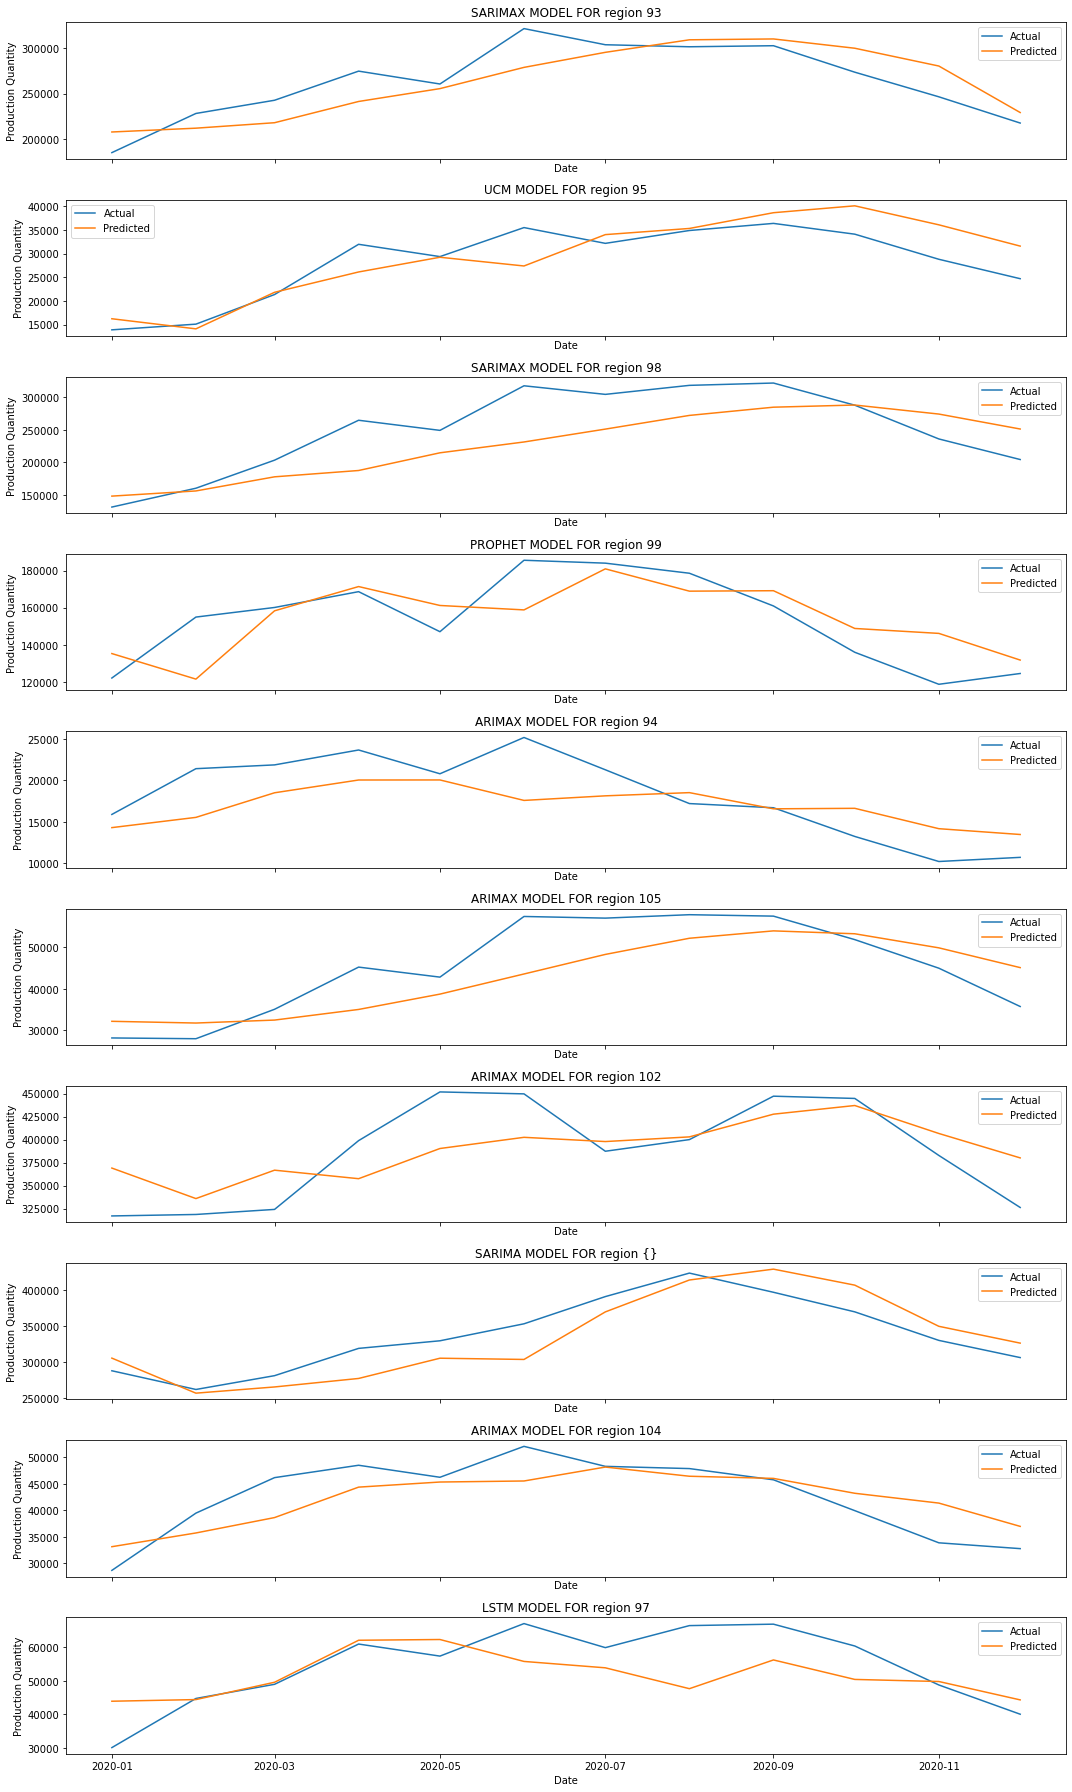

In [123]:
fig, axs = plt.subplots(10,figsize=(15,25),sharex=True)
j=0


forecast1=forecast.copy()
for i in final_data['region_id'].unique():
    #getting the dataframe for the particular region
    plot_df=final_data[final_data['region_id']==i]
    valid_data=plot_df[60:]
    valid_data.set_index('start_date',inplace=True)
    
    model_name= mape_df[mape_df['region_id']==i]['model'].item()
    
    #depending on the model used we are fetching the predicted values and plotting the results
    if model_name=='ARIMA':
        axs[j].set_title("ARIMA MODEL FOR region {}".format(i))
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_arima[pred_arima['region_id']==i]['predicted_mean'])
        
        
    elif model_name=='ARIMAX':
        axs[j].set_title("ARIMAX MODEL FOR region {}".format(i))
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_arimax[pred_arimax['region_id']==i]['predicted_mean'])
        
    elif model_name=='SARIMA':
        axs[j].set_title("SARIMA MODEL FOR region {}")
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_sarima[pred_sarima['region_id']==i]['predicted_mean'])
        
    elif model_name=='SARIMAX':
        axs[j].set_title("SARIMAX MODEL FOR region {}".format(i))
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_sarimax[pred_sarimax['region_id']==i]['predicted_mean'])
        
    elif model_name=='UCM':
        axs[j].set_title("UCM MODEL FOR region {}".format(i))
        axs[j].plot(valid_data['prod'])
        axs[j].plot(results_df[results_df['region_id']==i]['predicted_mean'])
        
    elif model_name=='PROPHET':
        axs[j].set_title("PROPHET MODEL FOR region {}".format(i))
        forecast1.rename(columns={'ds':'start_date'},inplace=True)
        forecast1.set_index("start_date",inplace=True)
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_prophet[pred_prophet['region_id']==i]['yhat'])
        
    else:
        axs[j].set_title("LSTM MODEL FOR region {}".format(i))
        axs[j].plot(valid_data['prod'])
        axs[j].plot(pred_lstm[pred_lstm['region_id']==i]['predicted_mean'])
        
        
    axs[j].set_ylabel("Production Quantity")
    axs[j].set_xlabel("Date")
    axs[j].legend(['Actual','Predicted'])
    j+=1
    fig.tight_layout()
    

#### Inference: 

The predicted results of all models manages to capture the trend of the data

## Now let us define the functions for our models for predicting the test data 

We will be using the best paramters we got from our training results to predict future trend

In [95]:
def arima_model(train,test,i,params):
    train.set_index('start_date',inplace=True)
    arima=ARIMA(train['prod'],order=(params[0],params[1],params[2])).fit()
    preds=arima.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1))
    results=preds.to_frame()
    results['region_id']=i
    return results


In [96]:
def arimax(train,test,i,params):
    train.set_index('start_date',inplace=True)
    exog_train=train[['precip','temp','ndvi']]
    exog_test=test[['precip','temp','ndvi']]
    arima= ARIMA(train['prod'],order=(params[0],params[1],params[2]),exog=exog_train).fit()
    preds=arima.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1),exog=exog_test)
    results=preds.to_frame()
    results['region_id']=i
    return results

In [97]:
def sarima(train,test,i,params):
    train.set_index('start_date',inplace=True)
    sarima= sm.tsa.statespace.SARIMAX(train['prod'],order=(params[0],params[1],params[2]),seasonal_order=(params[3],params[4],params[5],12)).fit()
    preds=sarima.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1))
    results=preds.to_frame()
    results['region_id']=i
    return results

In [98]:
def sarimax(train,test,i,params):
    train.set_index('start_date',inplace=True)
    exog_train=train[['precip','temp','ndvi']]
    exog_test=test[['precip','temp','ndvi']]
    sarimax= sm.tsa.statespace.SARIMAX(train['prod'],order=(params[0],params[1],params[2]),seasonal_order=(params[3],params[4],params[5],12),exog=exog_train).fit()
    preds=sarimax.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1),exog=exog_test)
    results=preds.to_frame()
    results['region_id']=i
    return results

In [99]:

unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True,
    'seasonal' : 12,'stochastic_trend' : True ,'level': True}


In [100]:
def ucm(train,test,i):
    train.set_index('start_date',inplace=True)
    exog_train=train[['precip','temp','ndvi']]
    exog_test=test[['precip','temp','ndvi']]
    ucm= sm.tsa.UnobservedComponents(endog=train['prod'],**unrestricted_model,exog=exog_train)
    ucm_model= ucm.fit(method='powell', disp=False)
    preds=ucm_model.predict(start=train.shape[0],end=(train.shape[0]+test.shape[0]-1),exog=exog_test)
    results=preds.to_frame()
    results['region_id']=i
    return results
    

In [101]:
def prophet(train,test,i):
    train=train[['start_date','prod','precip','temp','ndvi']]
    train.rename(columns={'start_date':'ds','prod':'y'},inplace=True)
    test1=test[['start_date','precip','temp','ndvi']]
    test1.rename(columns={'start_date':'ds'},inplace=True)
    my_model = Prophet(interval_width=0.95,daily_seasonality=False,weekly_seasonality=False,
                       yearly_seasonality=True)
    my_model.add_regressor('precip',standardize=False)
    my_model.add_regressor('temp',standardize=False)
    my_model.add_regressor('ndvi',standardize=False)
    my_model.fit(train)
    forecast = my_model.predict(test1)
    forecast['region_id']=i
    return forecast[['ds','yhat','region_id']]

In [102]:
def lstm(train,test,i):
    train=train[['start_date','prod','precip','temp','ndvi']]
    test=test[['start_date','precip','temp','ndvi']]
    test.set_index('start_date',inplace=True)
    train.set_index('start_date',inplace=True)
    trainX=train[['precip','temp','ndvi']]
    trainy=train[['prod']]
    testX=test[['precip','temp','ndvi']]
    scaler=MinMaxScaler(feature_range=(0, 1))
    trainX=scaler.fit_transform(trainX)
    testX=scaler.fit_transform(testX)
    trainy=scaler.fit_transform(trainy)
    trainX = np.reshape(trainX,(trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    model = Sequential()
    model.add(LSTM(64, input_shape=(1,trainX.shape[2]),return_sequences=True))
    model.add(LSTM(32, activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(10, activation='relu',return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(trainX, trainy, epochs=10, batch_size=1, verbose=2)
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX) 
    test_preds=np.reshape(testPredict,(testPredict.shape[0],1))
    pred_testy=scaler.inverse_transform(test_preds)
    pred_testy=pred_testy.flatten().tolist()
    return pred_testy

## Final Predictions

In [103]:
results=pd.DataFrame()
for i in test_df['region_id'].unique():
    region_df=test_df[test_df['region_id']==i]
    train=final_data[final_data['region_id']==i]
    best_model=mape_df[mape_df['region_id']==i]['model'].item()
    print(best_model)
    test=region_df.copy()
    #Defining the functions based on the best model for the region 
    if best_model=='ARIMA':
        params=params_arima[i]
        results_arima=arima_model(train,test,i,params)
        results=pd.concat([results,results_arima],axis=0)
        
    elif best_model=='ARIMAX':
        params=params_arimax[i]
        results_arimax=arimax(train,test,i,params)
        results=pd.concat([results,results_arimax],axis=0)
        
    elif best_model=='SARIMA':
        params=params_sarima[i]
        results_sarima=sarima(train,test,i,params)
        results=pd.concat([results,results_sarima],axis=0)
        
    elif best_model=='SARIMAX':
        params=params_sarimax[i]
        results_sarimax=sarimax(train,test,i,params)
        results=pd.concat([results,results_sarimax],axis=0)
        
    elif best_model=='UCM':
        results_ucm=ucm(train,test,i)
        results=pd.concat([results,results_ucm],axis=0)
        
    elif best_model=='PROPHET':
        results_prophet=prophet(train,test,i)
        results_prophet.set_index('ds',inplace=True)
        results_prophet.rename(columns={'yhat':'predicted_mean'},inplace=True)
        results=pd.concat([results,results_prophet],axis=0)
    else:
        results_lstm=lstm(train,test,i)
        ls = pd.DataFrame (results_lstm, columns = ['predicted_mean'])
        ls.set_index(results.index.unique(),inplace=True)
        ls['region_id']=i
        results=pd.concat([results,ls],axis=0)
results.drop_duplicates(inplace=True)

SARIMAX
SARIMA
UCM
LSTM
Epoch 1/10
72/72 - 1s - loss: 0.5100 - 1s/epoch - 20ms/step
Epoch 2/10
72/72 - 0s - loss: 0.2629 - 74ms/epoch - 1ms/step
Epoch 3/10
72/72 - 0s - loss: 0.1971 - 75ms/epoch - 1ms/step
Epoch 4/10
72/72 - 0s - loss: 0.2120 - 88ms/epoch - 1ms/step
Epoch 5/10
72/72 - 0s - loss: 0.2063 - 86ms/epoch - 1ms/step
Epoch 6/10
72/72 - 0s - loss: 0.1973 - 76ms/epoch - 1ms/step
Epoch 7/10
72/72 - 0s - loss: 0.2001 - 77ms/epoch - 1ms/step
Epoch 8/10
72/72 - 0s - loss: 0.2274 - 76ms/epoch - 1ms/step
Epoch 9/10
72/72 - 0s - loss: 0.2093 - 77ms/epoch - 1ms/step
Epoch 10/10
72/72 - 0s - loss: 0.2081 - 77ms/epoch - 1ms/step
SARIMAX
PROPHET
ARIMAX
ARIMAX
ARIMAX
UCM


In [104]:
#displaying the final results
results

,predicted_mean,region_id
2021-01-01,198735.819753,93
2021-02-01,195480.605082,93
2021-03-01,212482.800701,93
2021-04-01,230913.298593,93
2021-05-01,241447.844406,93
...,...,...
2021-08-01,38593.915357,105
2021-09-01,39236.618301,105
2021-10-01,39956.827037,105
2021-11-01,37772.921205,105


In [105]:
program_end_time=time.time()
print("The time taken to run the entire thread: ",program_end_time-program_start_time,"s")

The time taken to run the entire thread:  326.22605299949646 s


In [106]:
results.reset_index(inplace=True,drop=True)
results['start_date']=test_df['start_date']
results['end_date']=test_df['end_date']
results.rename(columns={'predicted_mean':'prod'},inplace=True)
results=results[['start_date','end_date','prod','region_id']]

In [107]:
results['region_id'].value_counts()

93     12
94     12
95     12
97     12
98     12
99     12
102    12
103    12
104    12
105    12
Name: region_id, dtype: int64

## Saving the data frame 

In [108]:
results.to_csv("predicted_production_qty1.csv",index=False)